# VAE using the reparametrization trick

## Imports and enabling of eager execution

In [1]:
import json
from collections import namedtuple
from functools import partial
import itertools
import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from functional import seq
from pathlib import Path
from functools import reduce

from importlib import reload # for debugging and developing, optional

import tensorflow as tf
import tensorflow.contrib as tfc
import tensorflow.contrib.eager as tfe
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp

# for the KL-loss explosion problem
from tensorflow.python.eager.execution_callbacks import InfOrNanError
from tensorflow.python.eager.core import _NotOkStatusException

tf.enable_eager_execution()
# we currently handle them ourselves. but with this, it will throw an error before we can apply the fix
tfe.seterr(inf_or_nan='raise')

# otherwise TF will print soooo many warnings
warnings.filterwarnings('ignore', '.*FutureWarning.*np.complexfloating.*')

from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
import som_vae.helpers.tensorflow as tf_helpers
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

from som_vae.settings.config import SetupConfig, RunConfig
from som_vae import data_loading
from som_vae import settings
from som_vae import preprocessing
from som_vae.helpers.misc import extract_args, chunks, foldl, if_last
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.settings import data as SD
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging

W0611 19:40:20.829231 139654823352128 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/helpers/tensorflow.py:5: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [2]:
jupyter.fix_layout()

## Constants (Settings)

In [3]:
# all those experiments and data will be used
#from som_vae.settings import config
#print(f"this is the main experiment, study, and fly id: {config.full_experiment_id()}.\n\nloadable experiments. there is a blacklist below.")
#!ls $config.__EXPERIMENT_ROOT__

In [4]:
# if you want to see the flys as well, or just more information
# !tree -L 2 $config.__EXPERIMENT_ROOT__

## Loading of 2d positional data

In [5]:
#if not run_config['use_all_experiments']:
#    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
#    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [6]:
# TODO form a wrapper around the used data, experiments (the ids), data, normalisation factor, images, ... a namedtuple should do the trick
#if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#    if run_config['use_all_experiments']:
#        all_experiments = [e for e in experiments_from_root() if e.study_id not in _EXPERIMENT_BLACK_LIST_ or config.get_experiment_id(e) in _FLY_BLACK_LIST_]
#        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(all_experiments, normalize_data=True)
#    else:
#        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS, normalize_data=True)
#
#        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
#                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
#                                               .to_list()
#
#        if len(frames_of_interest) != len(joint_positions):
#            warnings.warn('There is a bug here. The number of images and number of data points to NOT align.')
#            frames_of_interest = np.where(frames_of_interest[:len(joint_positions)])[0]
#        
#        joint_positions = joint_positions[frames_of_interest[:len(joint_positions)]]
#        frames_idx_with_labels = frames_idx_with_labels.iloc[frames_of_interest]
#        images_paths_for_experiments =  np.array(images_paths_for_experiments)[frames_of_interest].tolist()

## loading of angle-data

In [7]:
setup_cfg = SetupConfig()
run_cfg = RunConfig.ANGLE_3D()

frame_data, frame_labels = data_loading.load_labelled_data(run_config=run_cfg, setup_config=setup_cfg)

huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly4', experiment_id='003_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly4/003_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly4/003_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly3', experiment_id='001_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly6', experiment_id='003_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/003_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/

In [8]:
frame_data, frame_labels, selected_columns, normalisation_factors = preprocessing.preprocess_3d_angle_data(frame_data, frame_labels, **run_cfg.value('angle_3d_params', 'preprocessing'))

In [9]:
#if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_ and run_config['use_all_experiments']:
#    all_experiments = [e for e in experiments_from_root() if (e.study_id not in _EXPERIMENT_BLACK_LIST_) and (e.key not in _FLY_BLACK_LIST_)]
#    # `per_experiment` is a shitty parameter name, the data is not normalised and return per experiment.
#    loading_kwargs = {'dimensions': '3d', 'return_with_experiment_id': True}
#    angle_data_raw = [(exp_id, SD.convert_3d_to_angle(d)) for exp_id, d in preprocessing.get_data_and_normalization(all_experiments, **loading_kwargs)]
#
#    # takes for ever to render, if you want to see this, please run it yourself
#    #plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);
#
#    exp_ids, angle_data  = zip(*angle_data_raw)
#    angle_data = np.vstack(angle_data)
#    selected_cols = np.where(np.var(angle_data, axis=0) > 0.0)[0]
#    joint_positions = angle_data[:, selected_cols]

In [10]:
# will generate a huge plot and take about 6min to run...
#plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);

In [11]:
#all_experiments = experiments_from_root()
#print(len(all_experiments))
#
#pos_data = preprocessing.get_data_and_normalization(all_experiments, per_experiment=True)
#
#norm_pos_data, norm_pos_data_params = zip(*[preprocessing.normalize(p) for p in pos_data])
#experiment_lengths = [len(p) for p in norm_pos_data] # for applying the right normalization factors
#norm_pos_data = np.vstack(norm_pos_data)
#
#print(f"in total we have {len(all_experiments)} experiments, but only {len(experiment_lengths)} are usable right now")
#
#norm_pos_data_embedded = TSNE(n_components=2, random_state=42).fit_transform(norm_pos_data[:, :, :2].reshape(norm_pos_data.shape[0], -1))
#
##_cs = sns.color_palette(n_colors=len(seen_labels))
##
##fig = plt.figure(figsize=(10, 10))
##_all_frames_ = pd.concat((training_frames, testing_frames))
##
##behaviour_colours = dict(zip(seen_labels, _cs))
##
##for l, c in behaviour_colours.items():
##    _d = X_embedded[_all_frames_['label'] == l]
##    # c=[c] since matplotlib asks for it
##    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
##    
##plt.legend()
##plt.title('simple t-SNE on latent space')
##fig.savefig(f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_tsne.png")
#
#_cs = sns.color_palette(n_colors=len(experiment_lengths))
#
#
#used_until = 0
#for i, l in enumerate(experiment_lengths):
#    plt.scatter(norm_pos_data_embedded[used_until:used_until+l, 0], norm_pos_data_embedded[used_until:used_until+l, 1], c=[_cs[i]])
#    used_until += l

# preprocessing

In [12]:
scaler = StandardScaler()

n_data_points = int(frame_data.shape[0] * run_cfg['train_test_ratio'])

X_train = scaler.fit_transform(frame_data[:n_data_points])
X_test = frame_data[n_data_points:] 
y_train = frame_labels[:n_data_points]
y_test = frame_labels[n_data_points:]

if run_cfg['use_time_series']:
    X_train, X_test, y_train, y_test = [misc.to_time_series_np(x, sequence_length=run_cfg['time_series_length']) 
                                        for x in (X_train, X_test, y_train, y_test)]

In [13]:
## full preprocessing pipeline
#
## scaling the data to be in [0, 1]
## this is due to the sigmoid activation function in the reconstruction (and because ANN train better with normalised data) (which it is not...)
##scaler = MinMaxScaler()
#scaler = StandardScaler()
#
##
## reshapping the data 
##
#
## TODO bring this in order! (or in better order)
#
#if run_config['use_time_series']:
#    # it's the shitty logical combination of these values
#    # TODO the scaling should be learned on the training data only, but this is a bit tricky due to how we do the time-sequences
#    # TODO right now the training and testing data are just concatenated time-sequences, experiment overlapping. which is bad.
#    warnings.warn('this is not proper, fix the bugs here')
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        reshaped_joint_position = scaler.fit_transform(misc.prep_2d_pos_data(joint_positions))
#    else:
#        reshaped_joint_position = scaler.fit_transform(joint_positions)
#        
#    reshaped_joint_position = misc.to_time_series_np(reshaped_joint_position, sequence_length=run_config['time_series_length'])
#else:
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        # angle data is already flat
#        reshaped_joint_position = misc.prep_2d_pos_data(joint_positions)
#    else:
#        reshaped_joint_position = joint_positions
#
##
## debugging overwrite
##
#    
#if run_config['debug']:
#    if run_config['d_zero_data']:
#        # resetting the scaler to make our life easier down below the pipeline
#        _dummy_data_ = np.zeros_like(joint_positions)
#    elif run_config['d_sinoid_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            for frame in range(_dummy_data_.shape[0]):
#                for joint in range(_dummy_data_.shape[1]):
#                    _dummy_data_[frame, joint, :] = np.sin(2 * np.pi * frame/_dummy_data_.shape[0] + joint / _dummy_data_.shape[1])
#                
#        else:
#            _dummy_data_ = np.array([[np.sin(x) + (offset / joint_positions.shape[1]) 
#                                      for x in range(len(joint_positions))] 
#                                     for offset in range(joint_positions.shape[1])]).T.astype(joint_positions.dtype)
#    elif run_config['d_sinoid_cluster_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            raise NotImplementedError
#        else:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            _dummy_labels_ = np.zeros(joint_positions.shape[0])
#            for c in range(_dummy_data_.shape[1]):
#                _dummy_data_[:, c], _dummy_labels_ = dummy_data_complex_sine_like(_dummy_data_.shape[0])
#            
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        _dummy_data_ = misc.prep_2d_pos_data(_dummy_data_)
#        
#    if run_config['use_time_series']:
#        reshaped_joint_position = scaler.fit_transform(_dummy_data_)
#        reshaped_joint_position = misc.to_time_series_np(reshaped_joint_position, sequence_length=run_config['time_series_length'])
#        labels = _dummy_labels_[run_config['time_series_length'] - 1:]
#    else:
#        reshaped_joint_position = _dummy_data_
#        labels = _dummy_labels_
#
##
## split and apply scaler
##
#
#if reshaped_joint_position.shape[0] > 10**5:
#    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.9)
#else:
#    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)
#
#if run_config['use_time_series']:
#    data_train = reshaped_joint_position[:n_of_data_points]
#    data_test = reshaped_joint_position[n_of_data_points:]
#    labels_train = labels[:n_of_data_points]
#    labels_test = labels[n_of_data_points:]
#    print('train')
#    display.display(pd.DataFrame(data_train[:, -1, :]).describe())
#    print('test')
#    display.display(pd.DataFrame(data_test[:, -1, :]).describe())
#else:
#    data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
#    data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
#    labels_train = labels[:n_of_data_points]
#    labels_test = labels[n_of_data_points:]
#    print('train')
#    display.display(pd.DataFrame(data_train).describe())
#    print('test')
#    display.display(pd.DataFrame(data_test).describe())
#    
#print(f"shapes for train/test: {data_train.shape}, {data_test.shape}")

In [14]:
run_cfg.description(short=True)

'ANGLE_3D-t-16-k-2-ncl-4-ld-4-mf-T-opt-Adam-lwr-1.0-lwkl-0.0-dr-0.0-mi-SKIP_PADD_CONV-bn-T_d_sinoid_cluster_data'

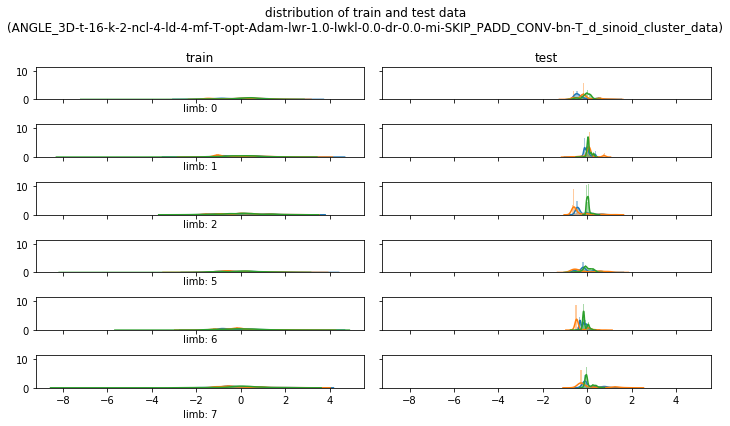

In [15]:
reload(plots)
#
# Making sure that the train/test distributions are not too different from each other
#
if run_cfg['use_time_series']:
    _plt_data_idx_ = np.s_[:, -1, :]
else:
    _plt_data_idx_ = np.s_[:]
    
if run_cfg['data_type'] == data_loading.DataType.ANGLE_3D:
    fig = plots.plot_3d_angle_data_distribution(X_train[_plt_data_idx_],
                                                X_test[_plt_data_idx_],
                                                selected_columns, 
                                                exp_desc=run_cfg.description())
else:
    fig = plots.plot_2d_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], exp_desc=config.config_description(run_config))

## Use *tf.data* to create batches and shuffle the dataset

In [16]:
def to_tf_data(X, y=None):
    if y is None:
        return tf.data.Dataset.from_tensor_slices(X).shuffle(len(X)).batch(run_cfg['batch_size'])
    else:
        return tf.data.Dataset.from_tensor_slices((X, y)).shuffle(len(X)).batch(run_cfg['batch_size'])

X_train_dataset= to_tf_data(X_train)
X_test_dataset = to_tf_data(X_test) 

# model def

## doc

### Sources:

- https://blog.keras.io/building-autoencoders-in-keras.html (keras autoencoder implementation)
- https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7 (temporal block)
- https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size (refresher on conv layers)
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d (refresher on conv layers)
- https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/ (for a good overview over diluted causal convolutions)
- https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=c5cb3c007035 (general reference)
- https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7 (VAE with tensorflow probability)

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)
![](./figures/WaveNet_gif.gif)

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

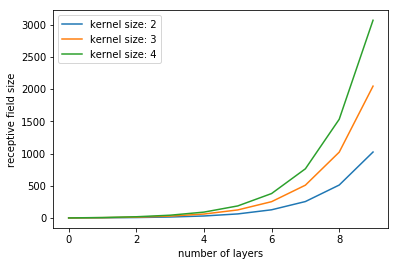

In [17]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## training

In [19]:
from som_vae.training import vae as vae_training

In [20]:
reload(vae_training)
model, checkpoint_path, train_writer, test_writer, optimizer = vae_training.init(input_shape=X_train.shape[1:], run_config=run_cfg)

W0611 19:40:27.460318 139654823352128 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/training/vae.py:19: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Using model: ModelType.SKIP_PADD_CONV


/home/sam/.local/opt/miniconda3/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py:174: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(numpy_dtype, np.complex) or


[18 17 16 15 15 14 13 13 12 11 10 10  9  8  8]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


W0611 19:40:30.899549 139654823352128 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/training/vae.py:54: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_2 (InputLayer)                         [(1024, 16, 18)]                        0              
____________________________________________________________________________________________________
inference_net (Sequential)                   (1024, 8)                               11564          
____________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlowOpLayer)      [(1024, 4), (1024, 4)]                  0              
____________________________________________________________________________________________________
activation_1 (Activation)                    (1024, 4)                               0              
Total params: 11,564
Trainable params: 11,186
Non-trainable params: 378
__

In [21]:
reload(vae_training)
model, optimizer, train_reports, test_reports = vae_training.train(model, optimizer, 
                                                                   train_summary_writer=train_writer,
                                                                   test_summary_writer=test_writer,
                                                                   train_dataset=X_train_dataset, 
                                                                   test_dataset=X_test_dataset)

W0611 19:40:31.838931 139654823352128 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/models/drosoph_vae.py:112: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0611 19:40:31.965655 139654823352128 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/losses/vae_loss.py:37: The name tf.losses.mean_squared_error is deprecated. Please use tf.compat.v1.losses.mean_squared_error instead.



Epoch: 0000, train/test loss: 1.928	 0.417 took 5.973 sec


In [22]:
# triplet, semi-supervised learning block init cell
triplet_epoch = 0

triplet_test_losses = np.array([]) 
triplet_train_losses = np.array([]) 
triplet_cur_train_reports = []
triplet_cur_test_reports  = []
triplet_cur_min_val_idx = 0
run_config['loss_weight_reconstruction'] = 1.0
run_config['loss_weight_kl'] = 0.0 # 1e-3

triplet_optimizer = tf.train.AdamOptimizer(1e-4)
#optimizer = tf.train.AdadeltaOptimizer(1e-4)
run_config['optimizer_triplet'] = optimizer._name
_model_checkpoints_encoder_path_ = f"{settings.config.__DATA_ROOT__}/models/{config.config_description(run_config, short=True)}_{_config_hash_}_encoder/checkpoint" 

labels_as_int = frames_idx_with_labels['label'].apply(lambda x: x.value).values
triplet_train_dataset = to_tf_data(data_train, labels_as_int[run_config['time_series_length'] - 1:len(data_train)+run_config['time_series_length'] - 1])
triplet_test_dataset = to_tf_data(data_test, labels_as_int[len(data_train) + run_config['time_series_length'] - 1:]) 

NameError: name 'run_config' is not defined

In [ ]:
# LOSS LABEL FUNCTION

def compute_loss_labels(x, labels):
    """About triplet loss: https://omoindrot.github.io/triplet-loss
    
    """
    #triplet_loss = tfc.losses.metric_learning.triplet_semihard_loss(labels, np.hstack((mean, var)))
    #loss = triplet_loss.batch_all_triplet_loss(labels, np.hstack((mean, var)), 0.1)
    loss, loss_fraction_pos = batch_all_triplet_loss(labels, x, 1., squared=True)
    #triplet_loss = tfc.losses.metric_learning.cluster_loss(labels, np.hstack((mean, var)), 0.1)
    
    return loss


def triplet_compute_gradients(model, x, y): 
    with tf.GradientTape() as tape: 
        #mean, var = model(x)
        #encoded = tf.nn.l2_normalize(((mean, var)))
        loss = compute_loss_labels(tf.concat(model(x), axis=1), y) 
        return tape.gradient(loss, model.trainable_variables), loss
    
    
def _compute_loss_for_data_triplet_(model, data):
    loss = tfe.metrics.Mean()
    for x, y in data:
        #mean, var = model(batch_x)
        #encoded = tf.nn.l2_normalize(((mean, var)))
        #loss_b = compute_loss_labels(mean, batch_y) 
        loss_b = compute_loss_labels(tf.concat(model(x), axis=1), y) 
        #loss_b = compute_loss_labels(model, batch_x, batch_y)
        loss(loss_b)
        
    return loss.result()

In [ ]:
#grad, loss = triplet_compute_gradients(model.inference_net, train_x, train_y)

In [ ]:
# debug
#from functools import partial
#
#def wrapped_cll(x, y):
#    return
#
#grad_fn = tfe.gradients_function()
#
#tf.expand_dims(tf.concat(_m(train_x), axis=1), axis=1).numpy().shape
#
#grad_y, grad_x = grad_fn(train_y, tf.concat(_m(train_x), axis=1))
#
#grad_x
#
#with tf.GradientTape() as tape: 
#    tape.watch(train_x)
#    loss = compute_loss_labels(_m, train_x, train_y) 
#    #print(model.inference_net.trainable_variables)
#    grad = tape.gradient(loss, _m.trainable_variables)
#
#loss, len(grad), len(_m.trainable_variables), grad[:3]
#
#with tf.GradientTape() as tape: 
#    loss = compute_loss(model, train_x) 
#    grad = tape.gradient(loss, model.trainable_variables)

In [ ]:
def _progress_str_triplet_(epoch, _cur_train_reports, _cur_test_reports, time=None, stopped=False):
    progress_str = f"Epoch: {epoch:0>4}, train/test loss: {_cur_train_reports[-1]:0.3f}\t {_cur_test_reports[-1]:0.3f}"
    if time:
        progress_str += f" took {time:0.3f} sec"
        
    if stopped:
        progress_str = "Stopped training during " + progress_str
        
    return progress_str

In [ ]:
# This is the run cell. Designed to be able to train the model.inference_net for an arbitrary amount of epochs.

from functools import partial

print(f"will train for ever...")
triplet_epoch = len(triplet_train_losses)

# todo wrap below code using this
#@tf.function
#def train(model, dataset, optimizer):
#    for x, y in dataset:
#        with tf.GradientTape() as tape:
#            prediction = model(x)
#            loss = loss_fn(prediction, y)
#        gradients = tape.gradient(loss, model.trainable_variables)
#        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#loss_fn = partial(batch_hard_triplet_loss, margin=1.)
#grad_fn = tfe.gradients_function(partial(compute_loss_labels, model=model.inference_net))

with warnings.catch_warnings():
    # pesky tensorflow again
    warnings.simplefilter(action='ignore', category=FutureWarning)
    while True:
        try:
            start_time = time.time()
            for train_x, train_y in triplet_train_dataset:
                gradients, loss = triplet_compute_gradients(model.inference_net, train_x, train_y)
                #loss = compute_loss_labels(model.inference_net, train_x, train_y) 
                #grad_y, gradients = grad_fn(train_y, train_x)
                apply_gradients(triplet_optimizer, gradients, model.inference_net.trainable_variables)
            end_time = time.time()

            triplet_cur_train_reports += [_compute_loss_for_data_triplet_(model.inference_net, triplet_train_dataset)]
            triplet_cur_test_reports += [_compute_loss_for_data_triplet_(model.inference_net, triplet_test_dataset)]
            
            _triplet_recorded_scalars_ =  ['triplet_loss']
            tf_helpers.tf_write_scalars(train_summary_writer, zip(_triplet_recorded_scalars_, [triplet_cur_train_reports[-1]]), step=triplet_epoch)
            tf_helpers.tf_write_scalars(test_summary_writer,  zip(_triplet_recorded_scalars_, [triplet_cur_test_reports[-1]]),  step=triplet_epoch)

            with train_summary_writer.as_default(), tfc.summary.always_record_summaries():
                for g, var_name in zip(gradients, [tf_helpers.tf_clean_variable_name(v.name) for v in model.inference_net.trainable_variables]):
                    tfc.summary.histogram(f'gradient_{var_name}', g, step=triplet_epoch)

            if triplet_epoch % 10 == 0:
                print(_progress_str_triplet_(triplet_epoch, triplet_cur_train_reports, triplet_cur_test_reports, time=end_time - start_time))
                tfc.summary.flush()
            else:
                # simple "loading bar"
                print('=' * (triplet_epoch % 10) + '.' * (10 - (triplet_epoch % 10)), end='\r')
                
            #if triplet_epoch > 10 and triplet_cur_test_reports[-1][0] < triplet_cur_test_reports[cur_min_val_idx][0]:
            #    cur_min_val_idx = triplet_epoch
            #    model.inference_net.save_weights(_model_checkpoints_path_)
                
            triplet_epoch += 1

            #if np.argmin(np.array(triplet_cur_test_reports)[:, 1]) < (len(triplet_cur_test_reports) - 10):
            #    # if there was no improvement in the last 10 epochs, stop it
            #    print('early stopping')
            #    break
        except KeyboardInterrupt:
            tfc.summary.flush()
            print(_progress_str_triplet_(triplet_epoch, triplet_cur_train_reports, triplet_cur_test_reports, stopped=True))
            break
        
        
tfc.summary.flush()
triplet_train_losses = np.array(triplet_cur_train_reports)
triplet_test_losses =  np.array(triplet_cur_test_reports)

# evaluation

In [ ]:
def _reverse_to_original_shape_(X):
    rescaled = scaler.inverse_transform(X)
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        return rescaled.reshape(-1, 15, 2)
    else:
        return rescaled

In [ ]:
# data pipeline for evaluation

exp_desc = config.exp_desc(run_config, {**model._config_(), 'epochs': len(train_losses)})
exp_desc_short = config.exp_desc(run_config, {**model._config_(), 'epochs': len(train_losses)}, short=True)
input_data_raw = np.vstack((data_train, data_test))

if run_config['use_time_series']:
    back_to_single_time = np.s_[:, -1, :]
else:
    back_to_single_time = np.s_[:]
    

input_data = _reverse_to_original_shape_(input_data_raw[back_to_single_time])
reconstructed_data = _reverse_to_original_shape_(model(input_data_raw, apply_sigmoid=False).numpy()[back_to_single_time])
    
_min_nb_batches_for_sample_length_ = int(np.ceil(len(input_data_raw) / run_config['batch_size']))
generated_data = _reverse_to_original_shape_(np.vstack([model.sample().numpy() for _ in range(_min_nb_batches_for_sample_length_)])[back_to_single_time])[:len(reconstructed_data)]

In [25]:
train_reports = np.array(train_reports)
test_reports= np.array(test_reports)

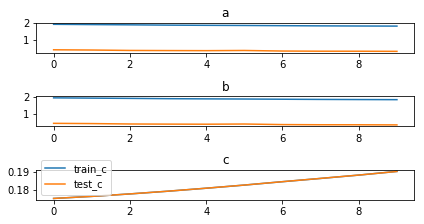

In [27]:
# losses
for a, n in zip(range(train_reports.shape[1]), ['a', 'b', 'c']):
    plt.subplot(train_reports.shape[1] + 1, 1, a + 1)
    plt.plot(train_reports[:, a], label=f"train_{n}")
    plt.plot(test_reports[:, a], label=f"test_{n}")
    plt.title(n)
    
plt.tight_layout()
plt.legend()

In [ ]:
plt.plot(triplet_train_losses)
plt.plot(triplet_test_losses)

In [ ]:
#plots.plot_losses(train_losses, test_losses, exp_desc=exp_desc);

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    fig = plots.plot_comparing_joint_position_with_reconstructed(input_data,
                                                                 reconstructed_data,
                                                                 generated_data,
                                                                 validation_cut_off=len(data_train),
                                                                 exp_desc=exp_desc_short);
else:
    # ncols is an ugly hack... it works on the basis that we have three working angles for each leg
    if run_config['use_all_experiments']:
        start = 100
        end = 1000
    else:
        start = 0
        end = len(input_data)
    xticks = np.arange(start, end)
    if run_config['debug']:
        _input_data = input_data_raw[:, :, 0]
        _recon = model(input_data_raw, apply_sigmoid=False).numpy()[:, :, 0]
        fig, axs = plt.subplots(nrows=_input_data.shape[-1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
        for i in range(_input_data.shape[-1]):
            _idx_ = np.s_[start:end, i]
            axs[i].plot(xticks, _input_data[_idx_], label='input')
            axs[i].plot(xticks, _recon[_idx_], label='reconstructed')
            #axs[i].plot(xticks, generated_data[_idx_], label='generated')

            #axs[i].set_title(cn)

            #for a in axs[i]:
            #    a.axvline(len(data_train), label='validation cut off', linestyle='--')
    else:
        fig, axs = plt.subplots(nrows=input_data.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
        for i, cn in enumerate(SD.get_3d_columns_names(selected_cols)):
            _idx_ = np.s_[start:end, i]
            axs[i].plot(xticks, input_data[_idx_], label='input')
            axs[i].plot(xticks, reconstructed_data[_idx_], label='reconstructed')
            #axs[i].plot(xticks, generated_data[_idx_], label='generated')

            axs[i].set_title(cn)

            #for a in axs[i]:
            #    a.axvline(len(data_train), label='validation cut off', linestyle='--')

    axs[-1].set_xlabel('time step')
    axs[0].legend(loc='upper left')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.suptitle(f"Comparision of selection of data\n({exp_desc})")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig(f"./figures/{exp_desc_short}_input_gen_recon_comparision.png")

# Latent space

In [ ]:
from hdbscan import HDBSCAN

In [ ]:
from collections import namedtuple
from sklearn.manifold import TSNE

LatentSpaceEncoding = namedtuple('LatentSpaceEncoding', 'mean var')

if run_config['use_all_experiments']:
    warnings.warn('should use all data `input_data`')
    if model._name in ['drosoph_vae_conv', 'drosoph_vae_skip_conv']:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(input_data_raw[np.random.choice(len(input_data), 10000)])))
    else:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(input_data_raw[np.random.choice(len(input_data), 10000)])))
else:
    if model._name in ['drosoph_vae_conv', 'drosoph_vae_skip_conv']:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(input_data_raw)))
    else:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(input_data_raw)))
    
X_latent_mean_tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(np.hstack((X_latent.mean, X_latent.var)))

In [ ]:
cluster_assignments = HDBSCAN(min_cluster_size=8).fit_predict(np.hstack((X_latent.mean, X_latent.var)))
cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

In [ ]:
from matplotlib.collections import LineCollection

def plot_debug(input_data, cluster_assignments, cluster_colors=None):
    _clusters = np.unique(cluster_assignments)
    _colors = sns.color_palette(n_colors=len(_clusters))
    if cluster_colors is None:
        cluster_colors = dict(zip(_clusters, _colors))
        
    lines, colors = zip(*[([(x, input_data[x, 0]) for x in segment], cluster_colors[cluster_id])
                           for cluster_id, segments in video.group_by_cluster(cluster_assignments).items() 
                           for segment in segments])


    
    fig, ax = plt.subplots(figsize=(10, 8))
    coll = LineCollection(lines, colors=colors)
    #coll.set_array(np.random.random(xy.shape[0]))

    ax.add_collection(coll)
    ax.autoscale_view()

    plt.title('Input data and cluster assigment using debug data');
    
if run_config['debug']:
    plot_debug(input_data, cluster_assignments)

In [ ]:
exp_desc_short

In [ ]:
# TODO
# use this to add a different shape to the scatter plot
# frames_idx_with_labels[:len(frames_of_interest)][frames_of_interest][run_config['time_series_length'] - 1:]['label'].apply(lambda x: x.value)

In [ ]:
from matplotlib import gridspec

labels = frames_idx_with_labels['label'].apply(lambda x: x.name)

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2, figure=fig)
ax1 = plt.subplot(gs[:2, :])
ax2 = plt.subplot(gs[-1:, :1])
ax3 = plt.subplot(gs[-1:, 1:])

#plt.figure(figsize=(20, 12))
#fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))
for cluster in np.unique(cluster_assignments):
    c_idx = cluster_assignments == cluster
    if run_config['use_all_experiments']:
        c_idx = c_idx & (np.random.random(len(c_idx)) > 0.7) # don't show all of them, takes for ever otherwise
    sns.scatterplot(X_latent_mean_tsne_proj[c_idx, 0], 
                    X_latent_mean_tsne_proj[c_idx, 1], 
                    label=cluster, 
                    ax=ax1,
                    color=cluster_colors[cluster], 
                    style=labels[run_config['time_series_length'] - 1:][c_idx],
                    legend='brief')
    sns.scatterplot(X_latent.mean[c_idx, 0], X_latent.mean[c_idx, 1], label=cluster, ax=ax2)
    sns.scatterplot(X_latent.var[c_idx, 0], X_latent.var[c_idx, 1], label=cluster, ax=ax3)
    
ax1.set_title('T-SNE proejection of latent space (mean & var stacked)')
ax2.set_title('mean')
ax3.set_title('var');

# videos

In [ ]:
def reverse_pos_pipeline(x, normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_factors[:x.shape[-1]]

def video_prep_raw_data(data):
    if run_config['use_time_series']:
        return reverse_pos_pipeline(scaler.inverse_transform(data[:, -1, :]).reshape(-1, 15, 2))
    else:
        return reverse_pos_pipeline(scaler.inverse_transform(data.reshape(-1, 30)).reshape(-1, 15, 2))
    
def video_prep_recon_data(input_data):
    return reverse_pos_pipeline(scaler.inverse_transform(model(input_data).numpy()).reshape(-1, 15, 2))

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    _positional_data_ = [reverse_pos_pipeline(input_data, normalisation_factors=normalisation_factors), 
                         reverse_pos_pipeline(reconstructed_data, normalisation_factors=normalisation_factors)]
else:
    raise NotImplementedError('give me a break')
    
p = video.comparision_video_of_reconstruction(_positional_data_,
                                              images_paths_for_experiments=images_paths_for_experiments, 
                                              n_train=len(data_train),
                                              cluster_assignments=cluster_assignments,
                                              as_frames=False,
                                              exp_desc=exp_desc_short)

display_video(p)

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    _positional_data_ = [reverse_pos_pipeline(input_data, normalisation_factors=normalisation_factors), 
                         reverse_pos_pipeline(reconstructed_data, normalisation_factors=normalisation_factors)]
else:
    raise NotImplementedError('give me a break')
    
p = video.comparision_video_of_reconstruction(_positional_data_,
                                              images_paths_for_experiments=images_paths_for_experiments, 
                                              n_train=len(data_train),
                                              cluster_assignments=cluster_assignments,
                                              as_frames=False,
                                              exp_desc=exp_desc_short)

display_video(p)

In [ ]:
# Super ugly... but necessary...
# first there is the time offset due to the slicing
# then there is the concatenation of the data...

angle_data_pos_to_frame = []

for exp_key, data in angle_data_raw: 
    _exp = SD._experiment_from_key_(exp_key)
    
    if len(angle_data_pos_to_frame) == 0:
        _idx = np.arange(data.shape[0])[run_config['time_series_length'] - 1:]
    else:
        _idx = np.arange(data.shape[0])# + len(angle_data_pos_to_frame)
        
    angle_data_pos_to_frame += [(_exp, d) for d in _idx]

In [ ]:
        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                               .to_list()

In [ ]:

    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [ ]:
images_paths_for_experiments = [(exp, config.get_path_for_image(exp, i)) for exp, i in angle_data_pos_to_frame]

In [ ]:
images_paths_for_experiments[-10:]

In [ ]:
reload(video)
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(input_data,
                                                                            cluster_assignments=cluster_assignments,
                                                                            images_paths_for_experiments=images_paths_for_experiments,
                                                                            n_train=data_train.shape[0],
                                                                            cluster_colors=cluster_colors,
                                                                            cluster_id_to_visualize=p[1], 
                                                                            exp_desc=exp_desc_short,
                                                                            is_2d=False))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
! cat ./som_vae/helpers/video.py

In [ ]:
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(_positional_data_,
                                                                      cluster_assignments=cluster_assignments,
                                                                      images_paths_for_experiments=images_paths_for_experiments,
                                                                      n_train=data_train.shape[0],
                                                                      cluster_colors=cluster_colors,
                                                                      cluster_id_to_visualize=p[1], exp_desc=exp_desc_short))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
#c_idx = 0
c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
c_idx = 0
#c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
images_paths_for_experiments

In [ ]:
len(np.where(cluster_assignments == 11)[0])

In [ ]:
np.array(images_paths_for_experiments)

In [ ]:
for fs, c in _t:
    print(f"cluster {c} has {len(fs)} elements")

In [ ]:
reload(video)

_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)
p = video.video_angle(cluster_assignments, images_paths_for_experiments, cluster_id_to_visualize=_t[3][1], exp_desc=exp_desc_short)

In [ ]:
display_video(p)

In [ ]:
stop

# Convolution Clarification

Below are the results shown for a Conv1d for all padding options:

- valid: only convolutions where the kernel fits inside the input are comptued
- causal: input is shifted such that the kernel can only see itself and backwards in time
- same: input is padded such that the convolution can also be applied to the border cases

kernel sizes of 2 & 3, and dilation rates for 1 to 3.

The result is that a valid convolution of kernel size 2 with a dilation factor of 1 compresses the input in a for us good way.
The data goes from `[batch_size, n_time_steps, n_channels]` to `[batch_size, n_time_steps - 1, n_filters]` 
and crops the first time step only. Thus building features by only looking backwards in time,
dropping the first-time step. Thus features are build over time and space.

In [ ]:
example_data = np.zeros((1, 10, 5), dtype=np.float32)

for row in range(example_data.shape[1]):
    example_data[:, row, :] = row
    
example_data

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], 1), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time


for kernel_size in range(2, 4):
    print(f"data\n{example_data}")
    print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
    for padding in ['valid', 'causal', 'same']:
        for dilation in range(1, 4):
            example_conv1d = tfkl.Conv1D(filters=1, 
                                         kernel_size=kernel_size,
                                         use_bias=False, 
                                         padding=padding,
                                         dilation_rate=dilation,
                                         kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

            conv_res = example_conv1d(example_data).numpy()
            print(f"padding: {padding}, dilation_rate: {dilation}, kernel_size: {kernel_size}, output shape: {conv_res.shape}\n{conv_res}")

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], example_conv1d_n_filters), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time

kernel_size = 2
padding = 'valid'
dilation_rate = 1
example_conv1d_n_filters = 2

print(f"data\n{example_data}")
print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
example_conv1d = tfkl.Conv1D(filters=example_conv1d_n_filters, 
                             kernel_size=kernel_size,
                             use_bias=False, 
                             padding=padding,
                             dilation_rate=dilation_rate,
                             kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

example_max_pooling_layer = tfkl.MaxPool1D()
example_dense = tfkl.Dense(2, use_bias=False, kernel_initializer='ones')

conv_res = example_conv1d(example_data[:,:2,:]).numpy()
#max_pool_res = example_max_pooling_layer(conv_res)
#dense_res = example_dense(max_pool_res)
print(f"padding: {padding}, dilation_rate: {dilation_rate}, kernel_size: {kernel_size}, output shape: {conv_res.shape}")
print('conv\n', conv_res)
#print('max pool\n', max_pool_res.numpy())
#print('dense\n', dense_res.numpy())

In [ ]:
conv_res

In [ ]:
class Conv1D_Transpose(tfkl.Layer):
    def __init__(self, n_filters, kernel_size, batch_size):
        super(Conv1D_Transpose, self).__init__()        
        self.n_filters = n_filters
        self.batch_size = batch_size
        self.conv2d_transpose = tfkl.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=2, padding='valid', kernel_initializer='ones')
        
    def call(self, inputs):
        x = tf.reshape(inputs, [self.batch_size, 1, *inputs.shape[1:]])
        print(x.shape)
        x = self.conv2d_transpose(x)
        #x = tf.reshape(x, [self.batch_size, -1, self.n_filters])
        
        return x

example_deconv1d = Conv1D_Transpose(n_filters=2, kernel_size=2, batch_size=1)
example_deconv1d(conv_res)

In [ ]:
_ted = example_deconv1d(conv_res)
tf.reshape(_ted, _ted.shape[:-1])

In [ ]:
UpsamplingConv(2)(conv_res)

In [ ]:
tfkl.UpSampling1D(3)(conv_res)

In [ ]:
class UpsamplingConv(tfkl.Layer):
    def __init__(self, n_filters, kernel_size=2):
        super(UpsamplingConv, self).__init__()
        
        self.n_filters = n_filters
        self.kernel_size = kernel_size
    
    def call(self, x): 
        x = tfkl.UpSampling1D(3)(x) # upscale with 3 so that we can again apply `valid` padding and "reverse" the encoder
        print(x.shape)
        # TODO maybe add some fancy flipping of the input
        x = tfkl.Conv1D(self.n_filters, self.kernel_size, padding='valid')(x)
        
        return x

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
example_deconv = tfkl.Conv2DTranspose(1, 2, kernel_initializer='ones')
example_deconv(conv_res.reshape(-1, 1, *conv_res.shape[1:])).numpy().reshape(-1, *conv_res.shape[1:])

In [ ]:
conv_res

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
tf.rank(conv_res)

In [ ]:
paddings = [[r, 0] for r in range(3)]
paddings

In [ ]:
tf.pad(conv_res, [[0, 0], [0, 1], [0, 0]])

In [ ]:
tfc.nn.conv1d_transpose(input=conv_res, filters=np.ones((2, 2, 2), dtype=np.float32), output_shape=[1, 2, 2], strides=1, padding='VALID')

In [ ]:
_pdc1dt = PaddedConv1dTransposed(n_filters=2)
print(conv_res.shape)
resc1 = _pdc1dt(conv_res)
print(resc1.shape)
resc1.numpy()

In [ ]:
_pdc1dt(_pdc1dt(resc1))

In [ ]:
#_t_layer_sizes_generative=[4,6,8,10,12,14,16,18]
#_t_layer_sizes_generative=[1] * 6
#_t_upsampling_size = [4] * 6 #, 2, 2]
#_t_strides = [2] * 6
##_t_padding = ['valid', 'valid', 'same']
##_t_layer_sizes_generative=[4, 8, 16]
#_latent_dim = 2
#_t_generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(_latent_dim,)),
#                                           tfkl.Lambda(lambda x: tf.reshape(x, [1000, 1, _latent_dim])),
#                                           *[TemporalUpsamplingConv(conv_n_filters=fs, 
#                                                                    upsampling_size=us,
#                                                                    conv_strides=s,
#                                                                    conv_padding='valid',
#                                                                    name=f"gen_conv_{i}") for i, (fs, us, s) 
#                                             in enumerate(zip(_t_layer_sizes_generative,
#                                                              _t_upsampling_size,
#                                                              _t_strides,
#                                                             ))]],
#                                          name='generative_net')
#
#_t_generative_net.summary()